# Setup

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [4]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

model_path = 'nasnetlarge_10split_LRStr.hdf5'

In [5]:
target_size = (331, 331)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.nasnet.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [6]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,1,ISIC_0025030,bkl,80.0,male,scalp
1,2,ISIC_0026769,bkl,80.0,male,scalp
2,3,ISIC_0025661,bkl,80.0,male,scalp
3,4,ISIC_0031633,bkl,75.0,male,ear
4,5,ISIC_0027850,bkl,75.0,male,ear


In [7]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,4966,ISIC_0029433,nv,35.0,male,trunk
1,5058,ISIC_0030113,nv,40.0,male,back
2,4321,ISIC_0027962,nv,50.0,female,upper extremity
3,128,ISIC_0032949,bkl,85.0,female,face
4,7739,ISIC_0033229,nv,5.0,female,back


## Training Data

In [7]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [8]:
any(elem is None for elem in train_img_lst)

False

In [9]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 331 331
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [8]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [9]:
any(elem is None for elem in val_img_lst)

False

In [10]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 331 331
Example of Age: 35.0
Example of Sex: male
Example of Localization: trunk


# Model

## Input Block

In [11]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [12]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [13]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding')>

In [14]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_1')>

In [15]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [16]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [17]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [18]:
NASNetLarge = tf.keras.applications.NASNetLarge(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)

inputs['image'] = NASNetLarge.input

# Exclude the last 28 layers of the model.
NASNetLarge_output = NASNetLarge.layers[-23].output

## Final Model

In [19]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(NASNetLarge_output.shape[-1]),name='soft_attention')(NASNetLarge_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
NASNetLarge_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(NASNetLarge_output))

NASNetLarge_output = layers.Concatenate()([NASNetLarge_output, attention_layer])
NASNetLarge_output = Activation('relu')(NASNetLarge_output)
NASNetLarge_output = Dropout(0.5)(NASNetLarge_output)

In [20]:
output = Flatten()(NASNetLarge_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             

Total params: 78,573,004
Trainable params: 78,389,773
Non-trainable params: 183,231
__________________________________________________________________________________________________


## Training

In [24]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [21]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [22]:
class_weights = { 
                    0: 4.37,  # akiec
                    1: 2.78,  # bcc
                    2: 1.3,  # bkl
                    3: 12.44,  # df
                    4: 1.28,  # mel
                    5: 0.21,  # nv
                    6: 10,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [27]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [29]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/CPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500, 
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 8407s 9s/step - loss: 1.8669 - accuracy: 0.3700 - val_loss: 71.1744 - val_accuracy: 0.6697 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 8345s 9s/step - loss: 1.9666 - accuracy: 0.3713 - val_loss: 74.4757 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 8345s 9s/step - loss: 1.8302 - accuracy: 0.4088 - val_loss: 246459.3125 - val_accuracy: 0.6606 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 8418s 9s/step - loss: 1.2702 - accuracy: 0.5516 - val_loss: 536.0817 - val_accuracy: 0.6195 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 8398s 9s/step - loss: 1.0033 - accuracy: 0.6137 - val_loss: 595.5758 - val_accuracy: 0.6335 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 8648s 10s/step - loss: 0.8811 - accuracy: 0.6678 - val_loss: 1.9152 - val_accuracy: 0.4307 - lr: 0.0010
Epoch 7/500
896/896 [===================

Epoch 48/500
896/896 [==============================] - 8445s 9s/step - loss: 0.0186 - accuracy: 0.9821 - val_loss: 0.5919 - val_accuracy: 0.8584 - lr: 3.2000e-07
Epoch 49/500
896/896 [==============================] - 8341s 9s/step - loss: 0.0251 - accuracy: 0.9799 - val_loss: 0.5921 - val_accuracy: 0.8584 - lr: 3.2000e-07
Epoch 50/500
896/896 [==============================] - 8247s 9s/step - loss: 0.0242 - accuracy: 0.9826 - val_loss: 0.5926 - val_accuracy: 0.8584 - lr: 3.2000e-07
Epoch 51/500
896/896 [==============================] - 8255s 9s/step - loss: 0.0205 - accuracy: 0.9816 - val_loss: 0.5927 - val_accuracy: 0.8574 - lr: 3.2000e-07
Epoch 52/500
897/896 [==============================] - ETA: -7s - loss: 0.0327 - accuracy: 0.9815
Epoch 00052: ReduceLROnPlateau reducing learning rate to 1e-07.
896/896 [==============================] - 8306s 9s/step - loss: 0.0327 - accuracy: 0.9815 - val_loss: 0.5932 - val_accuracy: 0.8574 - lr: 3.2000e-07
Epoch 53/500
896/896 [=============

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

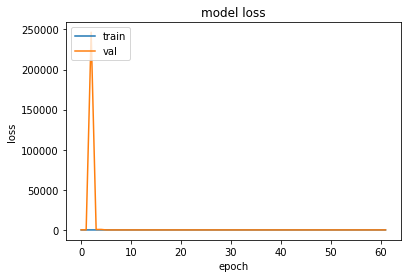

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from tensorflow.keras import models
model.load_weights(model_path)

In [25]:
batch_size = 32 
with tf.device('/CPU:0'):
    predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

# Classification report

In [26]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.79      0.79      0.79        33
         bcc       0.80      0.78      0.79        51
         bkl       0.80      0.81      0.80       109
          df       0.67      0.83      0.74        12
         mel       0.68      0.62      0.65       111
          nv       0.91      0.92      0.92       666
        vasc       1.00      0.93      0.96        14

    accuracy                           0.86       996
   macro avg       0.81      0.81      0.81       996
weighted avg       0.86      0.86      0.86       996



# Confusion Matrix Metrics

In [27]:
from sklearn.metrics import multilabel_confusion_matrix
multi_cm = multilabel_confusion_matrix(y_true, y_pred)
#print(multi_cm)

# TN     FP
# FN     TP

In [28]:
def cm_compute(_cm, _index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

### akiec       

In [29]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of akiec
[[956   7]
 [  7  26]]
True Positive of akiec: 26
False Positive of akiec: 7
False Negative of akiec: 7
True Negative of akiec: 956
Sensitivity of akiec: 0.7878787878787878
Specificity of akiec: 0.9927310488058152
Precision of akiec: 0.7878787878787878
Accuracy of akiec: 0.9859437751004017
Balanced Accuracy of akiec : 0.8903049183423015
F1 Score of akiec: 0.7878787878787878


### bcc       

In [30]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bcc
[[935  10]
 [ 11  40]]
True Positive of bcc: 40
False Positive of bcc: 10
False Negative of bcc: 11
True Negative of bcc: 935
Sensitivity of bcc: 0.7843137254901961
Specificity of bcc: 0.9894179894179894
Precision of bcc: 0.8
Accuracy of bcc: 0.9789156626506024
Balanced Accuracy of bcc : 0.8868658574540927
F1 Score of bcc: 0.7920792079207921


### bkl

In [31]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bkl
[[865  22]
 [ 21  88]]
True Positive of bkl: 88
False Positive of bkl: 22
False Negative of bkl: 21
True Negative of bkl: 865
Sensitivity of bkl: 0.8073394495412844
Specificity of bkl: 0.9751972942502819
Precision of bkl: 0.8
Accuracy of bkl: 0.9568273092369478
Balanced Accuracy of bkl : 0.8912683718957832
F1 Score of bkl: 0.8036529680365296


### df 

In [32]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of df
[[979   5]
 [  2  10]]
True Positive of df: 10
False Positive of df: 5
False Negative of df: 2
True Negative of df: 979
Sensitivity of df: 0.8333333333333334
Specificity of df: 0.9949186991869918
Precision of df: 0.6666666666666666
Accuracy of df: 0.9929718875502008
Balanced Accuracy of df : 0.9141260162601625
F1 Score of df: 0.7407407407407407


### mel

In [33]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of mel
[[852  33]
 [ 42  69]]
True Positive of mel: 69
False Positive of mel: 33
False Negative of mel: 42
True Negative of mel: 852
Sensitivity of mel: 0.6216216216216216
Specificity of mel: 0.9627118644067797
Precision of mel: 0.6764705882352942
Accuracy of mel: 0.9246987951807228
Balanced Accuracy of mel : 0.7921667430142006
F1 Score of mel: 0.647887323943662


### nv

In [34]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of nv
[[272  58]
 [ 51 615]]
True Positive of nv: 615
False Positive of nv: 58
False Negative of nv: 51
True Negative of nv: 272
Sensitivity of nv: 0.9234234234234234
Specificity of nv: 0.8242424242424242
Precision of nv: 0.9138187221396731
Accuracy of nv: 0.8905622489959839
Balanced Accuracy of nv : 0.8738329238329239
F1 Score of nv: 0.9185959671396564


### vasc

In [35]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of vasc
[[982   0]
 [  1  13]]
True Positive of vasc: 13
False Positive of vasc: 0
False Negative of vasc: 1
True Negative of vasc: 982
Sensitivity of vasc: 0.9285714285714286
Specificity of vasc: 1.0
Precision of vasc: 1.0
Accuracy of vasc: 0.998995983935743
Balanced Accuracy of vasc : 0.9642857142857143
F1 Score of vasc: 0.9629629629629629


## Weighted, Macro, Micro, ROC AUC

In [36]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8631440805613855
Recall: 0.8644578313253012
Accuracy: 0.8644578313253012
weighted Roc score: 0.9505320203041098


In [37]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.806404966417203
Recall: 0.8123545385514394
Accuracy: 0.8644578313253012
Macro Roc score: 0.9662858198882283


In [38]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.8644578313253012
Recall: 0.8644578313253012
Accuracy: 0.8644578313253012
Micro Roc score: 0.9832825277011661


In [39]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9520752698322792
The ROC AUC score of bcc is: 0.9794791990870422
The ROC AUC score of bkl is: 0.9665297932418315
The ROC AUC score of df is: 0.9964430894308943
The ROC AUC score of mel is: 0.9208428767750801
The ROC AUC score of nv is: 0.9487032487032487
The ROC AUC score of vasc is: 0.9999272621472215


In [40]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

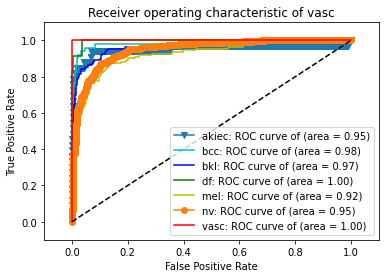

In [41]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()